# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments _upper_ (Maxilla) and _lower_ (Mandible) jaws in a DICOM file. _Backgound_ has label $0$, _lower_ jaw has label $1$, and _upper_ jaw has label $2$.

The Dataset is provided as 2D slices from all 3 orthogonal points of view [Axial, Coronal, and Sagittal](https://www.ipfradiologyrounds.com/hrct-primer/image-reconstruction/), if you're not familiar with what a [DICOM](https://en.wikipedia.org/wiki/DICOM) is, you're expected to read online about it. The value for each pixel is the [Hu value](https://en.wikipedia.org/wiki/Hounsfield_scale) which measures the radiodensity. Some typical values are: Air (-1,000), Water (0), Blood (13-50), Tissue (100-300), Bone (300-900), teeth (500-2,400), Metal (2,100-30,000).

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us or share it on google drive.

In [2]:
! pip install --user torch torchvision matplotlib numpy progressbar tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=6844ac0632883f67e39de27ac0ef53f157192b9dcab4ff6746d5342a3ebbefb4
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [3]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

In [4]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [ ]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


 90% (1532370944 of 1687658425) |####### | Elapsed Time: 0:02:20 ETA:   0:00:13

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you. You may need to explore class distribution, Hu values ranges, outliers, noise, etc. You may add your own transformations and/or augmentations.

In [5]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [6]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])

In [7]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


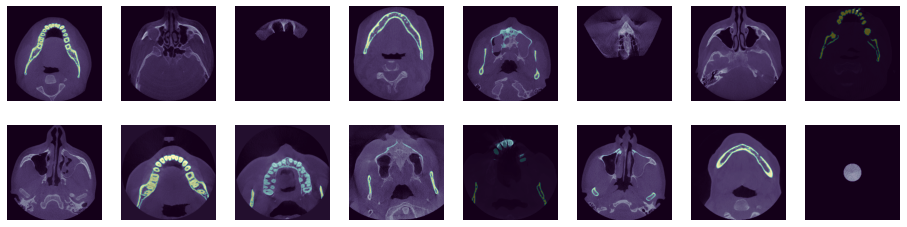

In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

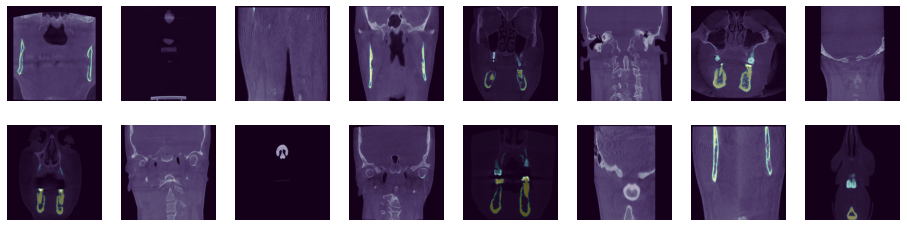

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

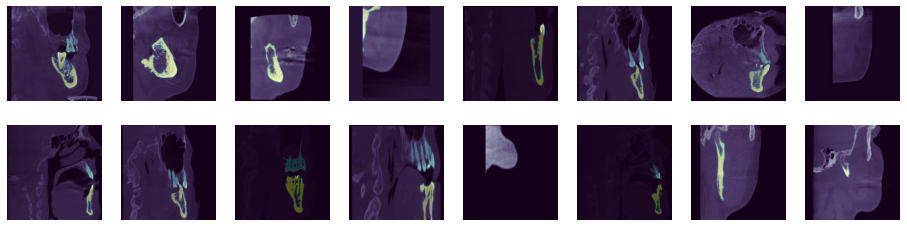

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

In [8]:
# import torch.segmentation_models_pytorch as smp
# single model for all views exp 
# experiment with 3 seperate models
class JawsDataset(torch.utils.data.Dataset):
    def __init__(self, dicom_file_list, transforms):
        self.dicom_file_list = dicom_file_list
        self.transforms = transforms

    def __len__(self):
        return len(self.dicom_file_list)

    def __getitem__(self, idx):
        dicom_path = self.dicom_file_list[idx]
        label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
        dicom_file = gzip.GzipFile(dicom_path, 'rb')
        dicom = np.load(dicom_file)
        label_file = gzip.GzipFile(label_path, 'rb')
        label = np.load(label_file)
        return self.transforms(dicom), self.transforms(label)


def full_dataset_train(transforms, validation_ration = 0.1):
    sagital_files= glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    files = sagital_files
    axial_files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    files.extend(axial_files)
    coronal_files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    files.extend(coronal_files)
    assert len(files) > 0
    validation_files_count = ceil(len(files)*validation_ration)
    
    return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))
	
def full_dataset_test(transforms):
    sagital_files= glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    files = sagital_files
    axial_files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    files.extend(axial_files)
    coronal_files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    files.extend(coronal_files)
    assert len(files) > 0

    return JawsDataset(files, transforms)




In [9]:
# get loaders 

dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
full_dataset_train, full_dataset_val = full_dataset_train(dataset_transforms, 0.2)
# full_dtaset_test = full_dataset_test(dataset_transforms)

full_train_loader = torch.utils.data.DataLoader(full_dataset_train,shuffle=True, batch_size=BATCH_SIZE)
full_val_loader = torch.utils.data.DataLoader(full_dataset_val, shuffle=True, batch_size=BATCH_SIZE)
# full_train_dataset_loader = torch.utils.data.DataLoader(full_dataset_train, shuffle=true, batch_size=BATCH_SIZE)

data_loaders = {'train': full_train_loader, 'val': full_val_loader}

In [10]:
from torchsummary import summary 
# original model had 3 channels for input
# https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
# number of classes ? doesn't require it (maybe hard set to 2)
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=1, out_channels=1, init_features=32, pretrained=False)


device = torch.device("cpu" if not torch.cuda.is_available() else 'cuda:0')
model.to(device)
# summary(model, (1, 256,256))

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [11]:
next(model.parameters()).is_cuda

True

In [12]:
import torch.nn as nn
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth)
        return 1. - dsc


In [13]:
import copy 
import time
from tqdm import tqdm 
# from logger import Logger

# note for later: add model batch normalization or add normalization to transform 
def train_model(model, optimizer, data_loaders, num_epochs=25,batch_size=1,
                save_path='model_train.pt'):
    since = time.time()
    vis_freq = 2
    vis_images = 1000

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dice_loss= DiceLoss()

    history = {'train_loss': [], 'valid_loss':[]}

    # logger = Logger(args.logs)
    loss_train = []
    loss_valid = []
    # best_validation_dsc = 0
    best_valid_loss = 3 # some relativly big loss
    step = 0
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            validation_pred = []
            validation_true = []
            
            # Iterate over data.
            for i, data in enumerate(data_loaders[phase]):
                # add batches and batch size
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    step += 1
                    y_pred = model(inputs)
                    loss = dice_loss(y_pred, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        history['train_loss'].append(loss.item())
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
                    
                    if phase == "val":
                       history['val_loss'].append(loss.item())   
                       loss_valid.append(loss.item())
                       y_pred_np = y_pred.detach().cpu().numpy()
                       validation_pred.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

                       y_true_np = labels.detach().cpu().numpy()
                       validation_true.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

                       if (epoch % vis_freq == 0) or (epoch == num_epochs - 1):
                            if i * batch_size < vis_images:
                                tag = "image/{}".format(i)
                                num_images = vis_images - i * batch_size
                                # logger.image_list_summary(
                                #     tag,
                                #     log_images(x, y_true, y_pred)[:num_images],
                                #     step,
                                # )

             
            if phase == "train" and (step + 1) % 10 == 0:
                    # log_loss_summary(logger, loss_train, step)
                    loss_train = []
                    # scheduler.step()


            if phase == 'val':
                curr_valid_loss = loss_valid[-1]
                if curr_valid_loss < best_valid_loss: 
                    best_valid_loss = curr_valid_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, save_path)
                    print('saved at epoch ', epoch)

                print("Best validation loss: {:4f}".format(best_valid_loss))
            # add visualisation
            


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return history


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0/31
----------


  3%|▎         | 1/32 [07:46<4:01:07, 466.70s/it]

saved at epoch  303
Best validation loss: -0.228658
Epoch 1/31
----------


  6%|▋         | 2/32 [15:38<3:54:53, 469.80s/it]

Best validation loss: -0.228658
Epoch 2/31
----------


  9%|▉         | 3/32 [23:29<3:47:20, 470.36s/it]

Best validation loss: -0.228658
Epoch 3/31
----------


 12%|█▎        | 4/32 [31:24<3:40:18, 472.09s/it]

Best validation loss: -0.228658
Epoch 4/31
----------


 16%|█▌        | 5/32 [39:13<3:31:55, 470.96s/it]

Best validation loss: -0.228658
Epoch 5/31
----------


 19%|█▉        | 6/32 [47:03<3:23:58, 470.69s/it]

Best validation loss: -0.228658
Epoch 6/31
----------


 22%|██▏       | 7/32 [54:52<3:15:52, 470.12s/it]

Best validation loss: -0.228658
Epoch 7/31
----------


 25%|██▌       | 8/32 [1:02:56<3:09:51, 474.65s/it]

Best validation loss: -0.228658
Epoch 8/31
----------


 28%|██▊       | 9/32 [1:10:55<3:02:22, 475.76s/it]

Best validation loss: -0.228658
Epoch 9/31
----------


 31%|███▏      | 10/32 [1:18:53<2:54:42, 476.49s/it]

saved at epoch  303
Best validation loss: -0.261584
Epoch 10/31
----------


 34%|███▍      | 11/32 [1:26:50<2:46:49, 476.63s/it]

Best validation loss: -0.261584
Epoch 11/31
----------


 38%|███▊      | 12/32 [1:34:52<2:39:28, 478.45s/it]

Best validation loss: -0.261584
Epoch 12/31
----------


 41%|████      | 13/32 [1:42:39<2:30:22, 474.87s/it]

Best validation loss: -0.261584
Epoch 13/31
----------


 44%|████▍     | 14/32 [1:50:24<2:21:34, 471.94s/it]

Best validation loss: -0.261584
Epoch 14/31
----------


 47%|████▋     | 15/32 [1:58:11<2:13:15, 470.34s/it]

saved at epoch  303
Best validation loss: -0.270283
Epoch 15/31
----------


 50%|█████     | 16/32 [2:05:57<2:05:04, 469.02s/it]

Best validation loss: -0.270283
Epoch 16/31
----------


 53%|█████▎    | 17/32 [2:13:43<1:57:03, 468.23s/it]

Best validation loss: -0.270283
Epoch 17/31
----------


 56%|█████▋    | 18/32 [2:21:33<1:49:20, 468.63s/it]

Best validation loss: -0.270283
Epoch 18/31
----------


 59%|█████▉    | 19/32 [2:29:19<1:41:23, 467.96s/it]

saved at epoch  303
Best validation loss: -0.275361
Epoch 19/31
----------


 62%|██████▎   | 20/32 [2:37:04<1:33:26, 467.17s/it]

Best validation loss: -0.275361
Epoch 20/31
----------


 66%|██████▌   | 21/32 [2:44:53<1:25:44, 467.71s/it]

Best validation loss: -0.275361
Epoch 21/31
----------


 69%|██████▉   | 22/32 [2:52:43<1:18:04, 468.44s/it]

Best validation loss: -0.275361
Epoch 22/31
----------


 72%|███████▏  | 23/32 [3:00:39<1:10:36, 470.73s/it]

Best validation loss: -0.275361
Epoch 23/31
----------


 75%|███████▌  | 24/32 [3:08:26<1:02:36, 469.52s/it]

Best validation loss: -0.275361
Epoch 24/31
----------


 78%|███████▊  | 25/32 [3:16:26<55:08, 472.70s/it]  

Best validation loss: -0.275361
Epoch 25/31
----------


 81%|████████▏ | 26/32 [3:24:11<47:02, 470.40s/it]

Best validation loss: -0.275361
Epoch 26/31
----------


 84%|████████▍ | 27/32 [3:31:59<39:07, 469.53s/it]

Best validation loss: -0.275361
Epoch 27/31
----------


 88%|████████▊ | 28/32 [3:39:47<31:16, 469.03s/it]

Best validation loss: -0.275361
Epoch 28/31
----------


 91%|█████████ | 29/32 [3:47:36<23:27, 469.01s/it]

Best validation loss: -0.275361
Epoch 29/31
----------


 94%|█████████▍| 30/32 [3:55:21<15:35, 467.88s/it]

Best validation loss: -0.275361
Epoch 30/31
----------


 97%|█████████▋| 31/32 [4:03:10<07:48, 468.23s/it]

Best validation loss: -0.275361
Epoch 31/31
----------


100%|██████████| 32/32 [4:10:55<00:00, 470.49s/it]

Best validation loss: -0.275361
Training complete in 250m 56s
Best val Acc: 0.000000


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1) #, varbos=True)
model_path = "unet_whole_Dataset_best.pt"

history = train_model(model, optimizer, data_loaders, num_epochs= 32,
                      batch_size = BATCH_SIZE, save_path=model_path)

In [ ]:
# other experiment with the whole model visible
from torch.nn import functional as F
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))


class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
  
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures


class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs


class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16), nbClasses=1, retainDim=True,
		 outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [ ]:
encoder_channels = (1, 16, 32,64)
decoder_channels = (64, 32, 16)

save_path= "unet_custom_whole.pt"
custom_unet = UNet(encoder_channels, decoder_channels, nbClasses=3, retainDim=True )



optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
history = train_model(custom_unet, optimizer, data_loaders, num_epochs= 32,
                      batch_size = BATCH_SIZE, save_path=save_path)

In [ ]:
# visualizing 
# check if the model saves history or if I need to visualize by saving the data as the model trains 

# plot the training loss
plot_path = 'train_val_graph.png'
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk


## Testing

Now you should run your trained model on the test dataset available below and report your results

In [ ]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_test_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_test_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [14]:
device='cuda'
model_path ='unet_whole_Dataset_best.pt'

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=1, out_channels=1, init_features=32, pretrained=False)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:

dice_loss = DiceLoss()

full_dtaset_test = full_dataset_test(dataset_transforms)
full_test_loader = torch.utils.data.DataLoader(full_dtaset_test, shuffle=True,
                                               batch_size=1)
totalTestLoss = 0 
outputs = []

for (image, mask_label) in full_test_loader:
    # send the input to the device
    if torch.cuda.is_available():
        (x, y) = (image.to(device), mask_label.to(device))
    else: 
        x,y = image, mask_label

    with torch.no_grad():
        pred = model(x)
        totalTestLoss += dice_loss(pred, y)
        outputs.append(pred)

print ("loss:" , totalTestLoss)
# calculate accuracy 
for output_mask in outputmasks:
    #  maybe save the images to draw the masks on them 
    print("not complete yet")
    break

loss: tensor(359.5782, device='cuda:0')


NameError: ignored

In [ ]:

def infer(model, data_loader, dest):
    dice_loss = DiceLoss()
    # data_iter = iter(data_loader)
    # images, labels = data_iter.next()
    totalTestLoss = 0

    outputs = []
    # plt.figure(figsize=(16, 4))
    for i, data in enumerate(data_loader):
        image, mask_label = data
        if torch.cuda.is_available():
            (x, y) = (image.to('cuda:0'), mask_label.to('cuda:0'))
        else:
            x, y = image, mask_label

        with torch.no_grad():
            pred = model(x)
            totalTestLoss += dice_loss(pred, y)
            image = image.cpu().detach().numpy()
            mask = pred.cpu().detach().numpy()
            # outputs.append(pred)
            # plt.imshow(image,)
            plt.imsave(os.path.join(dest, f"{i}_mask.png"), image, cmap='bone')
            masked_image = np.ma.masked_array(image, mask)
            plt.imsave(os.path.join(dest, f"{i}_masked.png"), masked_image)


model_path = 'unet_axial_Dataset_best.pt'
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=1, out_channels=1, init_features=32, pretrained=False)
model.load_state_dict(torch.load(model_path))
if torch.cuda.is_available():
    model.to('cuda')
model.eval()
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
axial_test_loader = data_loaders.axial_dataset_test(dataset_transforms)
dest_path = 'axial_results_axial_model'
if not os.path.exists(dest_path):
    os.mkdir(dest_path)
infer(model, axial_test_loader, dest_path)

